# Product analysis - BenNanna Bakery

The client is intrested mainly in understanding relationships between items. In this task our objective is to mine for these relationships using 5 years of transactional data and by leveraging the Apriori algorithim.

**The process:**  
1st - Clean the data.  
2nd - Exploratory Data Analysis.  
3rd - Market Basket Analysis.  

In [129]:
# Libraries import
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import pandas_profiling
import datetime as dt
import re
import warnings
warnings.filterwarnings('ignore')

In [89]:
# Creare a variable containing a dataframe with the data
df = pd.read_csv('Items-2016-2020.csv')

In [90]:
# Print the first 5 rows of data
df.head()

,Date,Time,Category,Item,Qty,Transaction ID
0,12/31/16,23:57:24,Breads,Swiss White,2,fdnGVxRa2XBw7Fnx8gtVqhxeV
1,12/31/16,23:57:24,Specialty,Oliebollen,1,fdnGVxRa2XBw7Fnx8gtVqhxeV
2,12/31/16,23:56:19,Specialty,Oliebollen,1,V4ri6t97vjyCzA7IdEQRyCleV
3,12/31/16,23:54:09,Specialty,Oliebollen,1,RS1iJSk5N0CWNwrfKBhvKW4eV
4,12/31/16,23:52:46,Specialty,Oliebollen,1,b7V19z0TRWRpafHX8PCBzn0eV


In [91]:
df.shape

(421189, 6)

We have managed to load in our data, the data contains 421189 rows and 6 columns. This data was extracted from the client POS software and filterd to only contain columns that are of intrest to the analysis. We will procede to clean the data.

# Data Cleaning

What do we intend to achieve with data cleaning ? Its important that the data is sane, in the sense that we do not have multiple names for the same product, multiple names for the same category, we do not have missing values and duplicated values. After we are happy that the data is in good condition we may proceed with the analysis.

## Categories

In [92]:
# List of unique categories
df['Category'].unique()

array(['Breads', 'Specialty', 'Buns', 'Puff Pastry', 'Pastry', 'Cookie',
       'Cakes', 'Frozen', 'Whole Sale', 'Baking supplies ', 'None',
       'Seasonal', 'Promotion', 'Lunch', 'Cakes and Pies',
       'Cakes &amp; Pies', 'Courses', 'Cakes & Pies', 'Sourdough',
       'Dairy', 'Online Store'], dtype=object)

In [93]:
# Correct misspelled category names
df['Category'].replace('Cakes &amp; Pies', 'Cakes & Pies', inplace = True)
df['Category'].replace('Cakes and Pies', 'Cakes & Pies', inplace = True)
df['Category'].replace('Cakes', 'Cakes & Pies', inplace = True)
df['Category'] = df['Category'].str.strip()

In [94]:
df['Category'].value_counts()

Pastry             192302
Breads              64018
Buns                42090
Sourdough           28326
Cakes & Pies        22395
Puff Pastry         17343
Specialty           16736
Cookie              15669
Promotion            6211
Frozen               5603
None                 3713
Seasonal             3640
Baking supplies      2705
Whole Sale            218
Dairy                 177
Online Store           23
Courses                12
Lunch                   8
Name: Category, dtype: int64

Categories are unique and clean, we can proceed to items.

## Items

In [95]:
df['Item'].nunique()

688

We have 688 unique items, i exported the whole list to an excel file to determine which items should be droped and found out the following:  
* We have items that contain (Voided) word, after consulting with the client we find out that these are canceled transactions. So we will remove all items that contaian the word voided in the name.  
* We have rows that contain promotional items, these contain the word voucher and should be removed.
* Some items have duplicated names, example coffee bars and coffee bar for the same item. These should be corrected.

In [96]:
# Remove void items
void_index = df.loc[df['Item'].str.contains('(Voided)')].index
print('Void Items: {}'.format(len(void_index)))
print('Rows before droping voided: {}'.format(df.shape[0]))
df.drop(void_index, axis = 0, inplace = True)
print(f'Rows after droping {len(void_index)} vodied products: {df.shape[0]}')

Void Items: 735
Rows before droping voided: 421189
Rows after droping 735 vodied products: 420454


In [97]:
# Remove voucher items
voucher_index = df.loc[df['Item'].str.contains('(Voucher)')].index
print('Void Items: {}'.format(len(voucher_index)))
print('Rows before droping voucher: {}'.format(df.shape[0]))
df.drop(voucher_index, axis = 0, inplace = True)
print('Rows after droping 266 vodied products: {}'.format(df.shape[0]))

Void Items: 266
Rows before droping voucher: 420454
Rows after droping 266 vodied products: 420188


In [98]:
# Remove leading spaces and change capitlization
df['Item'] = df['Item'].str.strip()
df['Item'] = df['Item'].str.lower()

In [99]:
# Create dictionar with items to replace
replace = {
    'bananna ã‰clair':'banana eclair','banana ã‰clair':'banana eclair','bienenstich torte - saturday feature':'bienenstich torte',
    'chocolate ã‰clair':'chocolate eclair', 'coffee bars':'coffee bar', 'fresh fruit whipping cream cake':'fresh fruit whipped cream cake',
    'ind oliebollen':'oliebollen','large baguetles':'large baguettes', 'mocha puffs':'mocha puff',
    'oliebollen individual' : 'oliebollen', 'over-the-top chocolate cake':'over the top chocolate cake', 'raspberry mousse' : 'rasberry mousse',
    'rosemary/oliveoil' : 'rosemary & olive oil', 'sausage roll':'sausage rolls', 'serious coconut': 'serious coconut tart',
    'sour dough' : 'sourdough', 'vanilla slices' : 'vanilla slice', 'bananna cream': 'bananna cream tart','benanna cream' : 'benanna cream cup',
    'lemon tarts' : 'lemon tart', 'mocha cake variable' : 'mocha cake', 'ã‰clair' : 'chocolate eclair',
    'chilliwack coconut loonie': 'coconut loonie', 'chwk coconut loonie' : 'coconut loonie',
    'choc cream puff' : 'chocolate cream puff','black forest variable':'black forest cake','puff pastry squares (6) frozen':'puff pastry frozen',
     'tiger logs' : 'tiger log', 'individual cookies': 'cookies'}

In [100]:
# Replace the wrong item names with the correct ones
df['Item'].replace(replace, inplace = True)

# Get top 159 items 
df['Item'].value_counts().head(159)

vanilla slice          22806
turnover               19204
new yorker             12074
rasberry mousse        11155
raisin buns            10942
                       ...  
2 for 1                  207
pizza                    204
coarse sugar             201
tart                     191
chocolate sourdough      191
Name: Item, Length: 159, dtype: int64

In [101]:
# Create list of items that we want to keep
items_keep = list(df['Item'].value_counts().head(159).index)

# Remove from that list all promotional items
remove_items = ['2 for $10 sourdough','2 for 1','2 for 1 > turnover','2 for one','5 for $10',
'5 for $10 pastries','5 for $12','5 for $12 pastries','custom amount',
'free bread','free pastry','groupon','misc.']
print(f'Unique items to be removed : {len(remove_items)}')
print(f'Total Unique items: {len(list(items_keep))}')
print(f'We should have {len(list(items_keep))-len(remove_items)} unique items left')

Unique items to be removed : 13
Total Unique items: 159
We should have 146 unique items left


In [130]:
# Remove all items from the keep list that exist in the remove list
for x in items_keep:
    if x in remove_items:
        items_keep.remove(x)
print(f'We are left with {len(items_keep)} unique items')

We are left with 146 unique items


We have now created a list that contains all items that are actual products and should be kept for the analysis. We now remove all rows that do not contain our items of intrest.

In [131]:
# Filter the data set to only contain items of intrest
df = df[df['Item'].isin(items_keep)]
df['Item'].value_counts()

vanilla slice          22601
turnover               18590
new yorker             11984
rasberry mousse        11045
raisin buns            10896
                       ...  
pumpkin tart             206
pizza                    204
coarse sugar             200
chocolate sourdough      188
tart                     162
Name: Item, Length: 146, dtype: int64

We now have 146 unique items are clean and we can use for our analysis. Now lets complete some general house cleaning and proceed to our exploratory data analysis phase.

In [132]:
# Check for missing values
df.isna().sum()

Date              0
Time              0
Category          0
Item              0
Qty               0
Transaction ID    0
dtype: int64

In [133]:
# Check for duplicated records
print(df.duplicated().sum())

# Drop duplicated values
df= df.drop_duplicates()

# Check for duplicated records
print(df.duplicated().sum())

0
0


In [134]:
# Check if we have negative quantities 
df['Qty'].describe()

# Looks like we do have negative quantities usualy returns. we are going to remove these transactions.

count    394089.000000
mean          1.649062
std           1.727145
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         300.000000
Name: Qty, dtype: float64

In [135]:
# Drop all returns
returns_index = df[df['Qty'] <= -1 ].index
df.drop(returns_index, axis = 0, inplace = True)

In [136]:
# How many rows do we have now ? 
print(f'We have {df.shape[0]} rows in our data set.')

# How many rows did we loose ? 
print(f'Through the cleaning phase we lost {421189 - 395379} rows which correspond to {(25810/421189) * 100}%')

We have 394089 rows in our data set.
Through the cleaning phase we lost 25810 rows which correspond to 6.127890329519527%


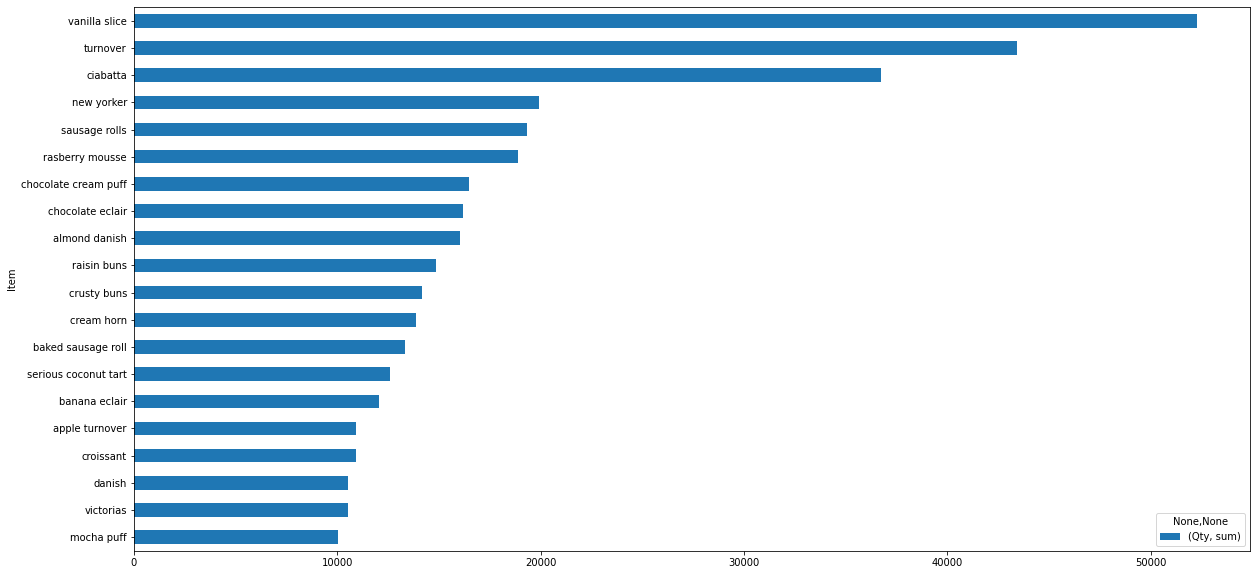

In [137]:
# Lets visualise the top 20 items by quantity sold.
df.groupby('Item').agg({
    'Qty':[sum]
}).nlargest(20,columns = ( 'Qty', 'sum')).sort_values(by = ( 'Qty', 'sum')).plot.barh(figsize=(20,10));

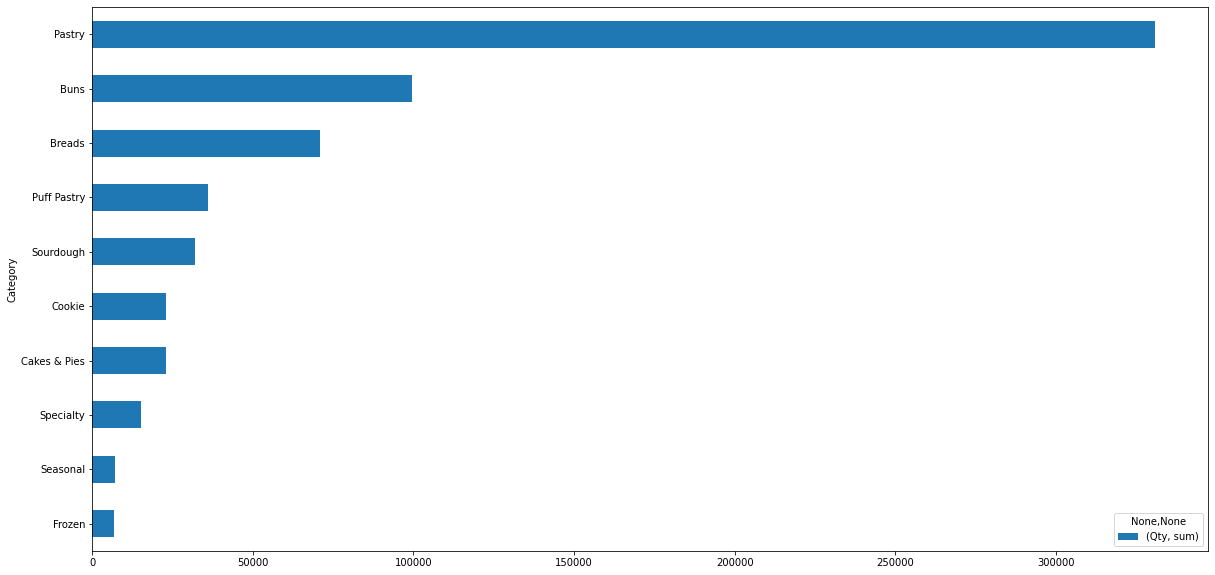

In [138]:
# Lets visualise categories by quantity sold.
df.groupby('Category').agg({
    'Qty':[sum]
}).nlargest(10,columns = ( 'Qty', 'sum')).sort_values(by = ( 'Qty', 'sum')).plot.barh(figsize=(20,10));

Our categories and items look good, we have compleated the first stage of any analytical project, the cleaning phase, now that we are confident that the data is clean and makes sense we can proceed to doing some exploratory analysis to better understand the data before we procced to mining for product associations.

In [139]:
# Save data
df.to_csv('Products_2016-2020.csv', index = False)

# Exploratory Data Analysis

Before we get to charting we are goinng to modify the data frame abit to make it easier to use for ploting.
We will combine the date and time columns in to one date-time column and from those extract extra date related columns and then proceed to awnsering some general questions about the data.

In [140]:
# Load clean data
data = pd.read_csv('Products_2016-2020.csv')

In [141]:
# Create date_time column, set to datetime format and drop Date and Time columns
data['date_time'] = data['Date'] + ' ' + data['Time']
data['date_time'] = pd.to_datetime(data['date_time'])
data.drop(['Date', 'Time'], axis = 1, inplace = True)

# Reorganize the dataframe
data = data[['Transaction ID', 'date_time', 'Category', 'Item', 'Qty']]

# Create extra date columns
data['year'] = data.date_time.dt.year
data['month'] = data.date_time.dt.month
data['week_name'] = data.date_time.dt.day_name()
data['week'] = data.date_time.dt.isocalendar().week
data['is_weekend'] = data.week_name.isin(['Saturday', 'Sunday'])
# Debug
data

,Transaction ID,date_time,Category,Item,Qty,year,month,week_name,week,is_weekend
0,fdnGVxRa2XBw7Fnx8gtVqhxeV,2016-12-31 23:57:24,Breads,swiss white,2,2016,12,Saturday,52,True
1,fdnGVxRa2XBw7Fnx8gtVqhxeV,2016-12-31 23:57:24,Specialty,oliebollen,1,2016,12,Saturday,52,True
2,V4ri6t97vjyCzA7IdEQRyCleV,2016-12-31 23:56:19,Specialty,oliebollen,1,2016,12,Saturday,52,True
3,RS1iJSk5N0CWNwrfKBhvKW4eV,2016-12-31 23:54:09,Specialty,oliebollen,1,2016,12,Saturday,52,True
4,b7V19z0TRWRpafHX8PCBzn0eV,2016-12-31 23:52:46,Specialty,oliebollen,1,2016,12,Saturday,52,True
...,...,...,...,...,...,...,...,...,...,...
394084,Xh7a9Q2BpRzrl0DSjuJZW1veV,2020-01-01 00:00:05,Breads,raisin bread,1,2020,1,Wednesday,1,False
394085,Xh7a9Q2BpRzrl0DSjuJZW1veV,2020-01-01 00:00:05,None,lemon sliders,1,2020,1,Wednesday,1,False
394086,Xh7a9Q2BpRzrl0DSjuJZW1veV,2020-01-01 00:00:05,Pastry,banana eclair,1,2020,1,Wednesday,1,False
394087,Xh7a9Q2BpRzrl0DSjuJZW1veV,2020-01-01 00:00:05,Pastry,gingerbread slice,1,2020,1,Wednesday,1,False


Looks good, the date columns will come in handy when we are analyzing the data by time. As we did with the cleaning stage lets begin by analysing our categories performance. For comparabilitiy reasons we will filter out the categories that do not exist in all of the 5 years of the data.

## Category

In [142]:
# What categories existed all the 5 years ? 
x = data.groupby(['Category','year'], as_index = False).size()
x = x.groupby('Category', as_index = False).agg({
    'year' : 'count'
})

categories = list(x[x['year']==5]['Category'])
categories.remove('None')
categories = data.loc[data['Category'].isin(categories)]
categories['Category'].unique()

array(['Breads', 'Specialty', 'Buns', 'Pastry', 'Cookie', 'Cakes & Pies',
       'Frozen', 'Baking supplies'], dtype=object)

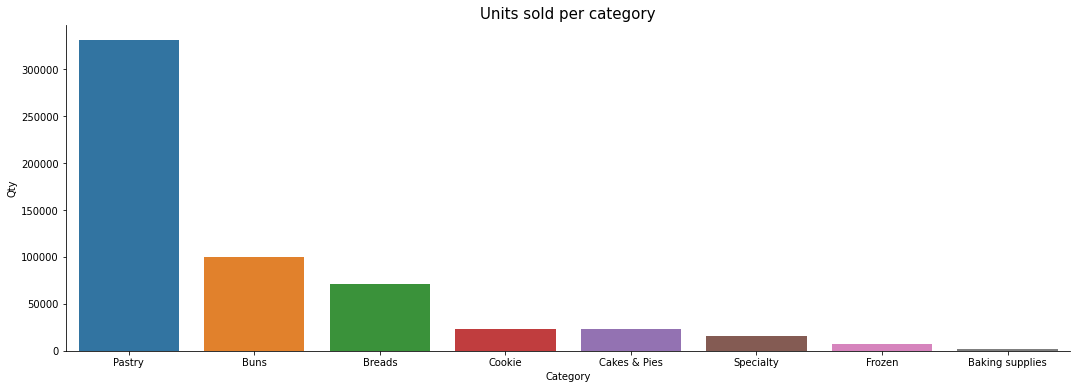

In [143]:
# What is the most popular category ? 
popular_category = categories.groupby(['Category', 'Transaction ID'], as_index = False).agg({'Qty':'sum'})
popular_category = popular_category.groupby(['Category'], as_index = False).sum()
popular_category = popular_category.sort_values(by = 'Qty', ascending = False)
plt.figure(figsize = (18,6));
sns.barplot(data = popular_category, x = 'Category', y = 'Qty');
sns.despine()
plt.title('Units sold per category', size = 15);

Pastries are by far the best selling category for bennanna bakery. Has this alwys been the case ? 

In [144]:
# Units sold by categories through out the past 5 years
year_categories = categories.groupby(['year','Category', 'Transaction ID'], as_index = False).agg({'Qty':'sum'})
year_categories = year_categories.groupby(['year','Category'],as_index = False).agg({'Qty':'sum'})
year_categories['Qty_log'] = np.log(year_categories['Qty'])
year_categories = year_categories.pivot("year", "Category", "Qty_log")
year_categories

Category,Baking supplies,Breads,Buns,Cakes & Pies,Cookie,Frozen,Pastry,Specialty
year,,,,,,,,
2016,4.912655,9.436360,9.566685,8.288534,7.863267,6.938284,10.791914,8.268475
2017,5.549076,9.876116,9.847235,8.404920,8.768885,7.318540,10.940366,8.509161
2018,6.082219,9.408863,9.976599,8.525360,8.615408,6.595781,11.235590,8.118207
2019,5.899897,9.451167,9.802285,8.421123,7.405496,7.304516,11.141673,7.505492
2020,6.410175,9.554568,10.194813,8.491260,8.829665,7.577634,11.302106,7.088409


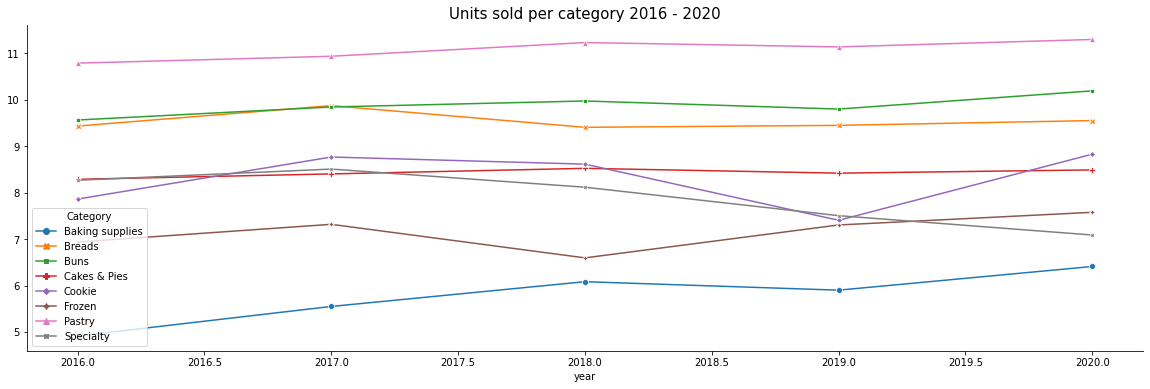

In [145]:
# Plot the data
plt.figure(figsize = (20,6))
sns.lineplot(data = year_categories, markers=True, dashes=False )
sns.despine()
plt.title('Units sold per category 2016 - 2020', size = 15);

We had to take the Log of quantity as to put all the data on the same scale so we can better compare the categories.
Pastries have always been the best selling category. Their growth looks to be quite steady compared to the other categories, lets look at the average YoY growth rate of each category as to get a better picture of which category is growing the fastest.

We will measure YoY growth as the percent increase or decrease of units sold from year 1 to year 2 etc and get the average for all the periods.

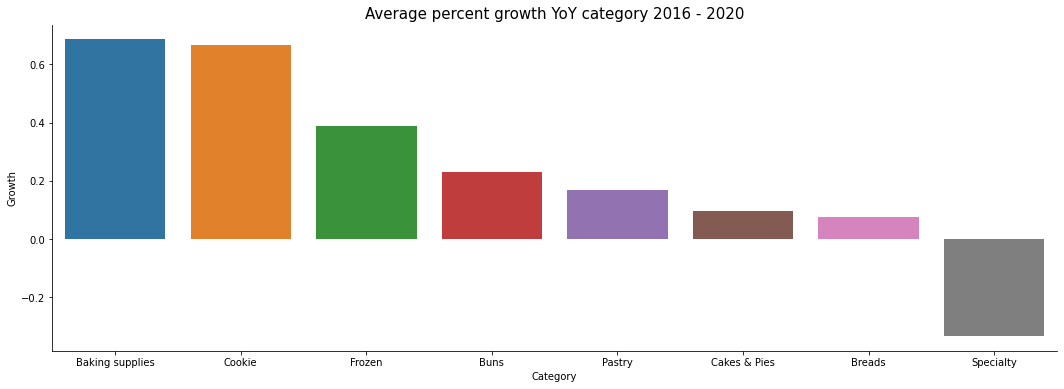

In [146]:
# What category is growing the most ? 
cat_growth = categories.groupby(['year','Category', 'Transaction ID'], as_index = False).agg({
    'Qty':'sum'
})
cat_growth = cat_growth.groupby(['year', 'Category'], as_index = False).agg({
    'Qty':'sum'
})

cats = list(cat_growth['Category'].unique())
growth = pd.DataFrame()

for category in cats:
    x = cat_growth[cat_growth['Category'] == category]['Qty']
    growth_rate = np.exp(np.diff(np.log(x))) - 1
    growth = growth.append(pd.DataFrame({'Category': category, 'Growth': growth_rate}), ignore_index=True)
    
growth = growth.groupby('Category', as_index = False).agg({
    'Growth':'median'
})

# Plot The results
plt.figure(figsize = (18,6));
sns.barplot(data = growth.sort_values(by= 'Growth', ascending = False), x = 'Category', y = 'Growth');
sns.despine()
plt.title('Average percent growth YoY category 2016 - 2020', size = 15);

Baking supplies and Cookie category are the fastest growing category with speciality bieng the only category not growing and acttualy shrinking. Lets do the same for our items.

## Items

In [147]:
# What Items exist in atleast 4 years of operation ? 
items_4 = data.groupby(['Item','year'], as_index = False).size()
items_4 = items_4.groupby('Item', as_index = False).agg({
    'year' : 'count'
})

items_4 = list(items_4[items_4['year']>=4]['Item'])

items_4 = data.loc[data['Item'].isin(items_4)]
items_4['Item'].unique()

array(['oliebollen', 'raisin buns', 'stollen', 'sausage rolls',
       'serious coconut tart', 'coconut loonie', 'black forest cake',
       'mocha cake', 'multigrain sourdough',
       'fresh fruit whipped cream cake', 'almond danish', 'new yorker',
       'vanilla slice', 'banana eclair', 'over the top chocolate cake',
       'danish', 'mocha puff', 'puff pastry frozen', 'rasberry mousse',
       'cream horn', 'squares', 'creamy cheesecake', 'victorias',
       'assorted pastries', 'chocolate eclair', 'sugar butterfly',
       'chocolate cream puff', 'rye bread', 'crusty buns',
       'diabetic puff', 'benanna cream cup', 'cranberry sourdough',
       'whipping cream', 'croissant', 'panko crumbs', 'hazelnut meringue',
       'shortbread cookies', 'chocolate rocks', 'bienenstich torte',
       'macaroon', 'cookies', 'cinnamon bun', 'coarse sugar',
       'pumpkin spice puff', 'raisin bread', 'strawberry extravaganza',
       'hot cross buns', 'bread crumbs', 'ginger snaps',
       'mu

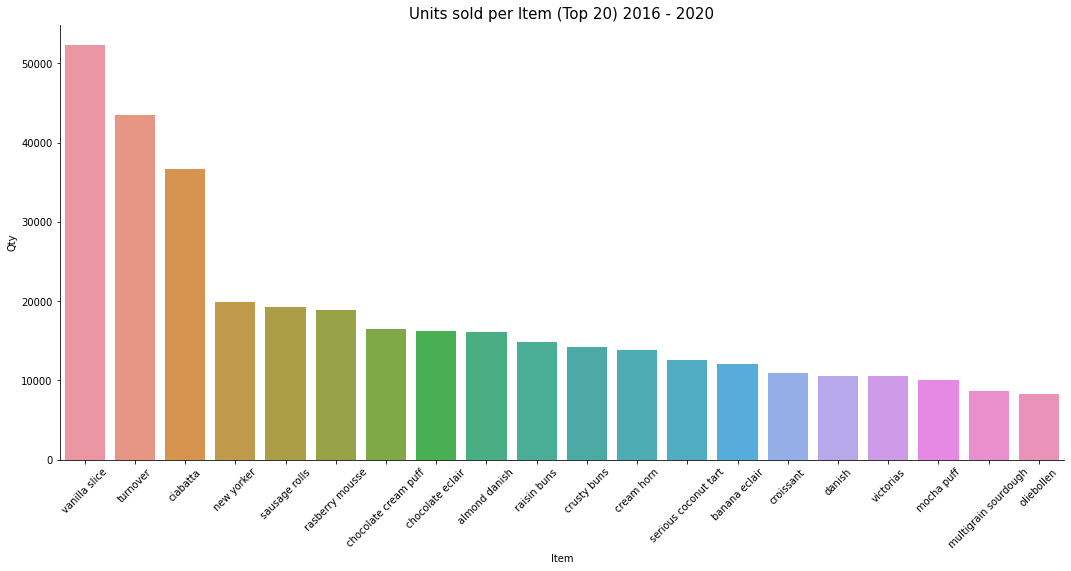

In [148]:
# What is the most popular item ? 
popular_items = items_4.groupby(['Item', 'Transaction ID'], as_index = False).agg({'Qty':'sum'})
popular_items = popular_items.groupby(['Item'], as_index = False).sum()
popular_items = popular_items.sort_values(by = 'Qty', ascending = False)
plt.figure(figsize = (18,8));
sns.barplot(data = popular_items.nlargest(20,'Qty'), x = 'Item', y = 'Qty');
sns.despine()
plt.xticks(rotation='45')
plt.title('Units sold per Item (Top 20) 2016 - 2020', size = 15);

Looks like most of the sales come from 3 items. 

In [149]:
# What items sales are growing ?
item_growth = items_4.groupby(['year','Item', 'Transaction ID'], as_index = False).agg({
    'Qty':'sum'
})
item_growth = item_growth.groupby(['year', 'Item'], as_index = False).agg({
    'Qty':'sum'
})
item_growth['Qty'] = np.log(item_growth['Qty'])

itemss = list(item_growth['Item'].unique())
growth_item = pd.DataFrame()

for item in itemss:
    x = item_growth[item_growth['Item'] == item]['Qty']
    growth_rate = np.exp(np.diff(np.log(x))) - 1
    growth_item = growth_item.append(pd.DataFrame({'Item': item, 'Growth': growth_rate}), ignore_index=True)
    
growth_item = growth_item.groupby('Item', as_index = False).agg({
    'Growth':'median'
})
growth_item.sort_values(by = 'Growth')

,Item,Growth
53,squares,-0.211328
24,crusty buns,-0.084638
28,fruit tarts,-0.069185
37,multigrain soft bread,-0.050377
51,shortbread cookies,-0.047342
...,...,...
17,coarse sugar,0.111397
9,bread crumbs,0.138515
22,creamy cheesecake,0.151136
6,bienenstich torte,0.233148


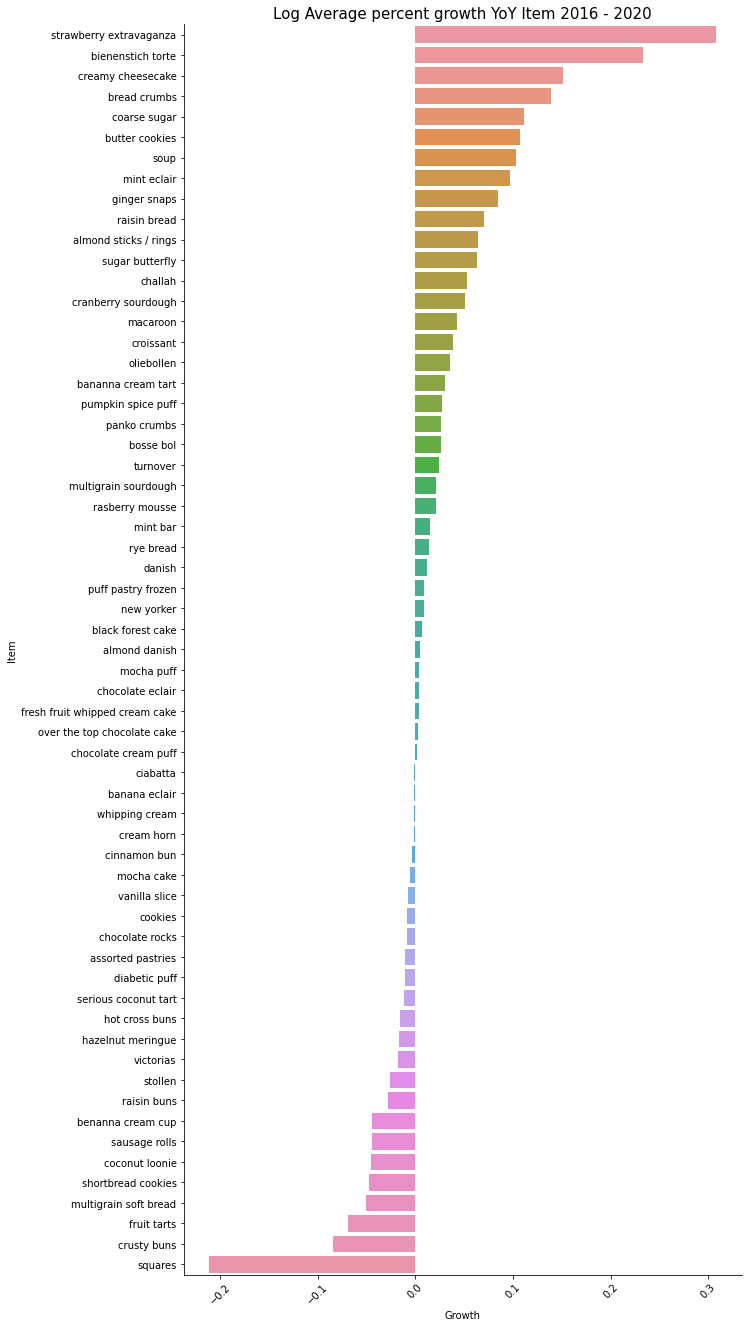

In [150]:
# Plot the data
plt.figure(figsize = (10,23));
sns.barplot(data = growth_item.sort_values(by= 'Growth', ascending = False), y = 'Item', x = 'Growth',orient= 'h');
sns.despine()
plt.xticks(rotation='45')
plt.title('Log Average percent growth YoY Item 2016 - 2020', size = 15);

More than 10 products are recording diminishing sales figures, mybe these products should be discontinued and resources allocated to the top growing products. Lets take focus on the transactions in general

## Transactions

In [151]:
# How many transactions in the dataset ? 
trans_ind = data['Transaction ID'].nunique()
print(f'We have {trans_ind} unique transactions')

We have 164817 unique transactions


In [152]:
# Describe Transactions
data.groupby('Transaction ID')['Qty'].sum().describe()

count    164817.000000
mean          3.943022
std           3.753711
min           1.000000
25%           2.000000
50%           3.000000
75%           5.000000
max         300.000000
Name: Qty, dtype: float64

Looks like the average transaction is made up of 3 items. How does the distribution look like ? 

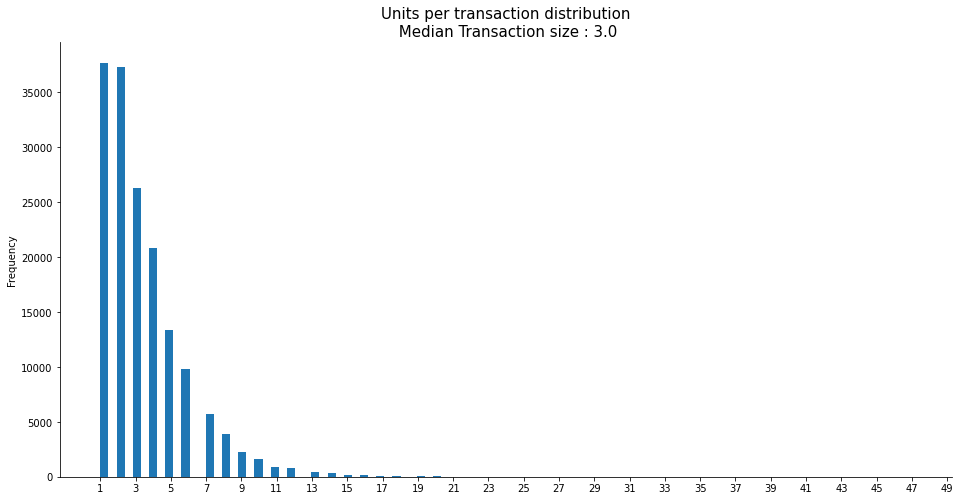

In [153]:
# How many products on in the average transaction ? 
ax = data[data['Qty']<= 5]
n_trans = len(ax.groupby('Transaction ID')['Qty'].sum())
ax.groupby('Transaction ID')['Qty'].sum().plot.hist(bins = 100, figsize = (16,8));
sns.despine()
plt.xticks(range(1,50,2))
plt.title(f'Units per transaction distribution\n Median Transaction size : {data.groupby("Transaction ID")["Qty"].sum().median()}'
          ,size = 15);
print(f'')

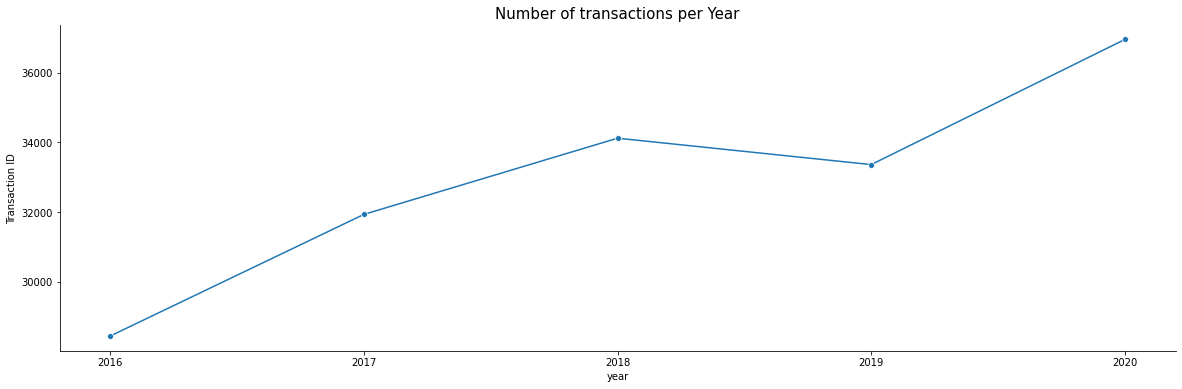

In [154]:
# Have transaction been increasing YoY ?
year_trans = data.groupby([data['year']], as_index = False)['Transaction ID'].nunique()

# Plot the data
plt.figure(figsize = (20,6))
sns.lineplot(data = year_trans, x ='year', y = 'Transaction ID', marker = 'o')
sns.despine()
plt.xticks(range(2016, 2021))
plt.title('Number of transactions per Year',size = 15);

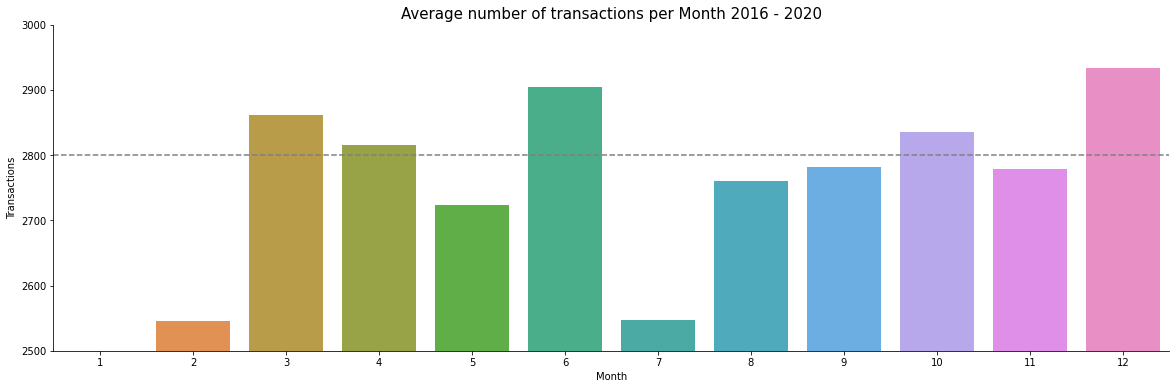

In [155]:
# What is the busiest day of the month ?
trans_month = data.groupby([data['year'], data['month']], as_index = False)['Transaction ID'].nunique()
trans_month = trans_month.groupby('month', as_index = False)['Transaction ID'].median()
trans_month['Transaction ID']
# Plot the data 
plt.figure(figsize = (20,6))
sns.barplot(data = trans_month, x = 'month', y = 'Transaction ID')
plt.ylabel('Transactions')
plt.xlabel('Month')
plt.axhline(2800, c = 'grey', ls = '--')
sns.despine()
plt.ylim(2500, 3000)
plt.title('Average number of transactions per Month 2016 - 2020',size = 15);

On average there is little differance between the months of the year in terms of the number of transactions, most months for the 5 years have been averaging above 2500 transactions a month, but we see that the months of march, june, september and december all average above 2800 transactions a month. We can consider these the busyest months of the year. What about week of day ? Is any day particularly busyier ? 

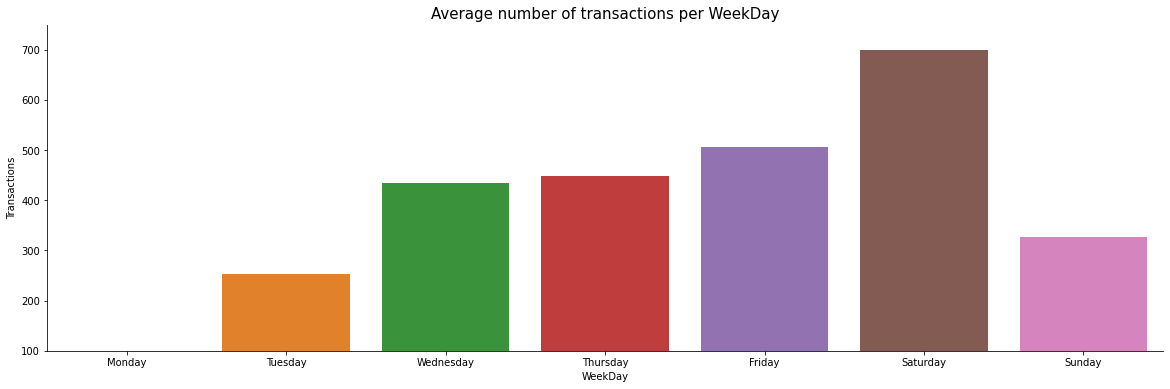

In [160]:
# What is the busiest day of the week ?
trans_week = data.groupby([data['year'], data['month'], data['week_name']], as_index = False)['Transaction ID'].nunique()
trans_week = trans_week.groupby('week_name')['Transaction ID'].median()
trans_week = pd.DataFrame(trans_week.loc[['Monday','Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']])
trans_week
# Plot the data 
plt.figure(figsize = (20,6))
sns.barplot(data = trans_week, x = trans_week.index, y = 'Transaction ID')
plt.ylabel('Transactions')
plt.xlabel('WeekDay')
sns.despine()
plt.ylim(100, 750)
plt.title('Average number of transactions per WeekDay',size = 15);

Monday is the least busiest day, probably because its the day the store is closed. Other wise we can see that Saturday is the busiest day.

# Market Basket Analysis

Market Basket Analysis is a technique which identifies the strength of association between pairs of products purchased together and identify patterns of co-occurrence. A co-occurrence is when two or more things take place together.

Market Basket Analysis creates If-Then scenario rules, for example, if item A is purchased then item B is likely to be purchased. The rules are probabilistic in nature or, in other words, they are derived from the frequencies of co-occurrence in the observations. Frequency is the proportion of baskets that contain the items of interest. The rules can be used in pricing strategies, product placement, and various types of cross-selling strategies.
To conduct the analysis we will use the the apriori algorithim and association rules mining.

### Apriori Algorithm 
Apriori is an algorithm used to identify frequent item sets (in our case, item pairs).  It does so using a "bottom up" approach, first identifying individual items that satisfy a minimum occurence threshold. It then extends the item set, adding one item at a time and checking if the resulting item set still satisfies the specified threshold.  The algorithm stops when there are no more items to add that meet the minimum occurrence requirement.  Here's an example of apriori in action, assuming a minimum occurence threshold of 3:


    order 1: apple, egg, milk  
    order 2: carrot, milk  
    order 3: apple, egg, carrot
    order 4: apple, egg
    order 5: apple, carrot

    
    Iteration 1:  Count the number of times each item occurs   
    item set      occurrence count    
    {apple}              4   
    {egg}                3   
    {milk}               2   
    {carrot}             2   

    {milk} and {carrot} are eliminated because they do not meet the minimum occurrence threshold.


    Iteration 2: Build item sets of size 2 using the remaining items from Iteration 1 
                 (ie: apple, egg)  
    item set           occurence count  
    {apple, egg}             3  

    Only {apple, egg} remains and the algorithm stops since there are no more items to add.
   
   
If we had more orders and items, we can continue to iterate, building item sets consisting of more than 2 elements.  For the problem we are trying to solve (ie: finding relationships between pairs of items), it suffices to implement apriori to get to item sets of size 2.

### Association Rules Mining
Once the item sets have been generated using apriori, we can start mining association rules.  Given that we are only looking at item sets of size 2, the association rules we will generate will be of the form {A} -> {B}.  One common application of these rules is in the domain of recommender systems, where customers who purchased item A are recommended item B.

Here are 3 key metrics to consider when evaluating association rules:

1. <b>support</b>  
    This is the percentage of orders that contains the item set. In the example above, there are 5 orders in total 
    and {apple,egg} occurs in 3 of them, so: 
       
                    support{apple,egg} = 3/5 or 60%
        
    The minimum support threshold required by apriori can be set based on knowledge of your domain.  In this 
    grocery dataset for example, since there could be thousands of distinct items and an order can contain 
    only a small fraction of these items, setting the support threshold to 0.01% may be reasonable.<br><br><br>
    
2. <b>confidence</b>  
    Given two items, A and B, confidence measures the percentage of times that item B is purchased, given that 
    item A was purchased. This is expressed as:
       
                    confidence{A->B} = support{A,B} / support{A}   
                    
    Confidence values range from 0 to 1, where 0 indicates that B is never purchased when A is purchased, and 1 
    indicates that B is always purchased whenever A is purchased.  Note that the confidence measure is directional.     This means that we can also compute the percentage of times that item A is purchased, given that item B was 
    purchased:
       
                    confidence{B->A} = support{A,B} / support{B}    
                    
    In our example, the percentage of times that egg is purchased, given that apple was purchased is:  
       
                    confidence{apple->egg} = support{apple,egg} / support{apple}
                                           = (3/5) / (4/5)
                                           = 0.75 or 75%

    A confidence value of 0.75 implies that out of all orders that contain apple, 75% of them also contain egg.  Now, 
    we look at the confidence measure in the opposite direction (ie: egg->apple): 
       
                    confidence{egg->apple} = support{apple,egg} / support{egg}
                                           = (3/5) / (3/5)
                                           = 1 or 100%  
                                           
    Here we see that all of the orders that contain egg also contain apple.  But, does this mean that there is a 
    relationship between these two items, or are they occurring together in the same orders simply by chance?  To 
    answer this question, we look at another measure which takes into account the popularity of <i>both</i> items.<br><br><br>  
    
3. <b>lift</b>  
    Given two items, A and B, lift indicates whether there is a relationship between A and B, or whether the two items 
    are occuring together in the same orders simply by chance (ie: at random).  Unlike the confidence metric whose 
    value may vary depending on direction (eg: confidence{A->B} may be different from confidence{B->A}), 
    lift has no direction. This means that the lift{A,B} is always equal to the lift{B,A}: 
       
                    lift{A,B} = lift{B,A} = support{A,B} / (support{A} * support{B})   
    
    In our example, we compute lift as follows:
    
         lift{apple,egg} = lift{egg,apple} = support{apple,egg} / (support{apple} * support{egg})
                         = (3/5) / (4/5 * 3/5) 
                         = 1.25    
               
    One way to understand lift is to think of the denominator as the likelihood that A and B will appear in the same 
    order if there was <i>no</i> relationship between them. In the example above, if apple occurred in 80% of the
    orders and egg occurred in 60% of the orders, then if there was no relationship between them, we would 
    <i>expect</i> both of them to show up together in the same order 48% of the time (ie: 80% * 60%).  The numerator, 
    on the other hand, represents how often apple and egg <i>actually</i> appear together in the same order.  In 
    this example, that is 60% of the time.  Taking the numerator and dividing it by the denominator, we get to how 
    many more times apple and egg actually appear in the same order, compared to if there was no relationship between     them (ie: that they are occurring together simply at random).  
    
    In summary, lift can take on the following values:
    
        * lift = 1 implies no relationship between A and B. 
          (ie: A and B occur together only by chance)
      
        * lift > 1 implies that there is a positive relationship between A and B.
          (ie:  A and B occur together more often than random)
    
        * lift < 1 implies that there is a negative relationship between A and B.
          (ie:  A and B occur together less often than random)
        
    In our example, apple and egg occur together 1.25 times <i>more</i> than random, so we conclude that there exists 
    a positive relationship between them.
   
Armed with knowledge of apriori and association rules mining, let's dive into the data and code to see what relationships we unravel!

In [161]:
# Load in the libraries we will need
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [162]:
# Create our basket 
basket = (data.groupby(['Transaction ID', 'Item'])['Qty']
          .sum().unstack().reset_index().fillna(0)
          .set_index('Transaction ID'))

In [163]:
# Create unit encode function
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets = basket.applymap(encode_units)

In [165]:
# Debug our basket set
basket_sets.sample(5)

Item,almond butter bars,almond danish,almond filled cookies,almond sticks / rings,anna's dips,apple turnover,artisan swiss bread,assorted frozen cakes,assorted pastries,assorted squares,authentic country bread,bacon/onion,baguettes,baguettes filled,baked sausage roll,banana eclair,bananna cream tart,benanna cream cup,berliner bollen,bienenstich torte,black forest cake,blueberry mousse,bokke pootjes,bosse bol,bread crumbs,butter cookies,butterfly cookies,challah,cheese bread,cheese sourdough,chocolate cream puff,chocolate eclair,chocolate rocks,chocolate sourdough,ciabatta,ciabatta buns,cinnamon bun,coarse sugar,coconut cream cup,coconut loonie,...,roasted garlic bread,roasted garlic sourdough,rosemary & olive oil,rosemary & olive oil sourdough,rosemary sea salt ciabatta bread,rye bread,sandwich bread,sausage rolls,serious coconut tart,shortbread cookies,soft white dinner buns,soup,sourdough,sourdough plain,sourdough starter,specialty bread,specialty sourdough,spinach dip,squares,stollen,strawberry delite,strawberry extravaganza,strawberry torte,sugar butterfly,sunflower flax sourdough,sunflower sourdough,swiss,swiss white,tart,tiger log,tiger pastry,trifle,turnover,vanilla slice,victorias,whipping cream,white buns,whole wheat sourdough,whole wheat stone ground,yummy strawberry
Transaction ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
vFMUfre2nKFXySAFsk0MBWteV,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Pb5PQyPd2SOkOx2TQxP2dNleV,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BsYNOYiaSmFS2SKgRFoNYdweV,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
py9N9RS2trm0qvdwL1ceea8eV,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
DhA48uHknvi1UbA1aqzJK09eV,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Each row contains a unique transaction were each column is an item where there is a 1 if that item was purchased in that transacion and a 0 if not. 

In [166]:
# Generate frequent item sets that have a support of at least 1% :
frequent_itemsets = apriori(basket_sets, min_support=0.01, use_colnames=True)
frequent_itemsets.sort_values(by='support',ascending=False) 

,support,itemsets
60,0.136303,(vanilla slice)
59,0.111518,(turnover)
33,0.072523,(new yorker)
40,0.066656,(rasberry mousse)
39,0.066037,(raisin buns)
...,...,...
79,0.010351,"(victorias, rasberry mousse)"
75,0.010296,"(mocha puff, vanilla slice)"
43,0.010254,(rosemary & olive oil)
69,0.010096,"(chocolate cream puff, victorias)"


In [167]:
# The final step is to generate the rules with their corresponding support, confidence and lift:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(banana eclair),(chocolate eclair),0.047192,0.062833,0.012584,0.266650,4.243760,0.009618,1.277925
1,(chocolate eclair),(banana eclair),0.062833,0.047192,0.012584,0.200270,4.243760,0.009618,1.191413
2,(banana eclair),(vanilla slice),0.047192,0.136303,0.014501,0.307277,2.254372,0.008069,1.246815
3,(vanilla slice),(banana eclair),0.136303,0.047192,0.014501,0.106388,2.254372,0.008069,1.066243
4,(chocolate cream puff),(chocolate eclair),0.058726,0.062833,0.012863,0.219031,3.485903,0.009173,1.200005


# Conclusion

We have found that there are items that do occur together not by chance as indicated by the lift metric. These item relationships should be investigated by the person with best domain knowledge as to understand the nature of the relationship and how to best take advantage of them.